In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import pandas as pd
pd.set_option('display.max_columns',None)
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn import preprocessing,cluster
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_samples,silhouette_score,davies_bouldin_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,make_scorer
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso,LogisticRegression
from sklearn.metrics import precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

import xgboost as xgb

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

import statsmodels as sm
from scipy import stats

from time import time

from imblearn.under_sampling import RandomUnderSampler

from warnings import simplefilter
simplefilter("ignore")

# 1. EDA

In [4]:
raw = pd.read_csv('travel.csv')
raw.head()

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,24636210,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68
1,19837144,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37
2,13066459,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22
3,4691082,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42
4,4878884,2014-06-10 13:34:56,2,3,66,174,50644,NaN,596177,0,0,9,2014-08-03,2014-08-08,2,1,1,12812,5,0,1,2,50,368,83


In [5]:
raw.columns

Index(['Unnamed: 0', 'date_time', 'site_name', 'posa_continent',
       'user_location_country', 'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

## 1.1 Data Quality Check

In [7]:
raw.info() #check for data types and missing rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 100000 non-null  int64  
 1   date_time                  100000 non-null  object 
 2   site_name                  100000 non-null  int64  
 3   posa_continent             100000 non-null  int64  
 4   user_location_country      100000 non-null  int64  
 5   user_location_region       100000 non-null  int64  
 6   user_location_city         100000 non-null  int64  
 7   orig_destination_distance  63915 non-null   float64
 8   user_id                    100000 non-null  int64  
 9   is_mobile                  100000 non-null  int64  
 10  is_package                 100000 non-null  int64  
 11  channel                    100000 non-null  int64  
 12  srch_ci                    99878 non-null   object 
 13  srch_co                    998

In [8]:
date_cols = ['date_time', 'srch_ci', 'srch_co']

for col in date_cols:
    # convert to datetime object
    raw[col] = pd.to_datetime(raw[col], errors='coerce')

Most of the columns are categorical given the column name/description + data type as integer. Columns that have cnt in their names suggests they represent count of things thus are not categorical but numerical columns but only contain whole numbers.

is_mobile/is_package/is_booking are binary features.

### 1.1.1 Missing values

The missing values appear in 2 set of columns:

1. destination distance
2. srch_ci/co

We first evaluate if missing values can be easily filled by digging into the root cause.

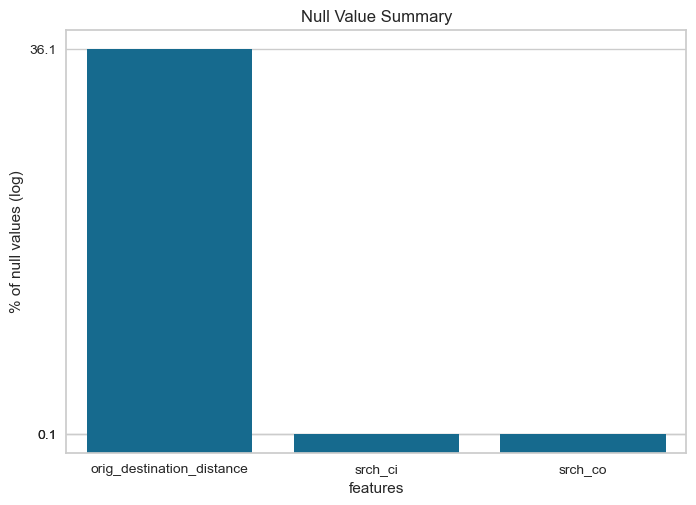

<Figure size 800x550 with 0 Axes>

,index,count,pct_count
7,orig_destination_distance,36085,36.085
12,srch_ci,122,0.122
13,srch_co,122,0.122


In [11]:
def plot_nulls(data, title, x_axis_label, y_axis_label):
    
    # number of nulls for each column
    data_nulls = data.isnull().sum().reset_index(name='count')
    data_nulls['pct_count'] = data_nulls['count']/len(data)*100
    data_nulls = data_nulls.loc[data_nulls['count'] > 0]

    sns.barplot(x='index', y='pct_count', data=data_nulls)
    plt.yscale('log')  # Log spacing
    plt.yticks(data_nulls['pct_count'], labels=data_nulls['pct_count'].round(1))
    plt.title(title)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.show()
    
    plt.tight_layout()
    plt.show()
    
    return data_nulls
    
nulls = plot_nulls(raw, 'Null Value Summary', 'features', '% of null values (log)')
nulls

There are 122 rows missing srch_ci & co, they represent <1% of the data. These 2 columns derive the duration of the stay, which could play an important role in model training later. We will likely remove rows missing this information later considering minimal impacted rows.

There is ~36% of the data missing distance to destination. While further investigation could be conducted to the root cause, we will continue the analysis dropping rows missing this information. In the practical setting, an alterntive solution would be to use third-party information fill the missing information based on user location and destination location to get a close approximation.

In summary, we examine the missing values in the data with the following decision: removing rows with missing information.

### 1.1.2 Duplicates

In [14]:
# check for duplicates
duplicates = raw.loc[raw.duplicated()]
duplicates

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster


We did not observe any duplicating rows in the dataset.

### 1.1.3 Unique Values

In [17]:
unique = raw.nunique()
unique.reset_index(name='count').sort_values(by='count')

,index,count
19,is_booking,2
9,is_mobile,2
10,is_package,2
3,posa_continent,5
21,hotel_continent,7
18,srch_destination_type_id,8
16,srch_rm_cnt,9
14,srch_adults_cnt,10
15,srch_children_cnt,10
11,channel,11


We observe that:
* is_booking, is_mobile, and is_package are 3 binary features
* posa_continent, hotel_continent, srch_destination_type_id, and channel are categorical variables with a few options available
* Max room count is 9, max adult and children count are both 10
* There are duplicating user_ids in the dataset
* Other columns are more dispersed. Further cleaning and pre-processing are likely required before model training if ever used.

In [19]:
raw.describe().round(2)

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,100000.00,100000,100000.00,100000.00,100000.00,100000.00,100000.00,63915.00,100000.00,100000.00,100000.00,100000.00,99878,99878,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,18825295.01,2014-04-03 07:16:45.412640256,9.84,2.68,86.00,308.64,27676.39,1960.66,605438.33,0.13,0.25,5.86,2014-05-28 05:17:03.432587776,2014-05-31 14:15:37.575842304,2.02,0.34,1.11,14426.33,2.58,0.08,1.49,3.15,81.09,598.85,49.86
min,1012.00,2013-01-07 00:33:47,2.00,0.00,0.00,0.00,0.00,0.01,14.00,0.00,0.00,0.00,2013-01-07 00:00:00,2013-01-08 00:00:00,0.00,0.00,0.00,4.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
25%,9448967.00,2013-10-24 19:31:17.249999872,2.00,3.00,66.00,174.00,12949.00,312.79,298796.25,0.00,0.00,2.00,2013-12-23 00:00:00,2013-12-27 00:00:00,2.00,0.00,1.00,8267.00,1.00,0.00,1.00,2.00,50.00,158.00,25.00
50%,18812118.00,2014-05-30 09:21:38,2.00,3.00,66.00,314.00,27655.00,1131.84,602882.50,0.00,0.00,9.00,2014-07-17 00:00:00,2014-07-20 00:00:00,2.00,0.00,1.00,9145.00,1.00,0.00,1.00,2.00,50.00,591.00,49.00
75%,28253073.50,2014-09-18 07:40:03,15.00,3.00,70.00,385.00,42328.00,2542.36,915722.25,0.00,0.00,9.00,2014-11-09 00:00:00,2014-11-13 00:00:00,2.00,0.00,1.00,18784.00,5.00,0.00,2.00,4.00,106.00,701.00,73.00
max,37670090.00,2014-12-31 23:47:14,53.00,4.00,239.00,1025.00,56507.00,11965.38,1198783.00,1.00,1.00,10.00,2016-05-10 00:00:00,2016-05-13 00:00:00,9.00,9.00,8.00,65035.00,9.00,1.00,120.00,6.00,212.00,2117.00,99.00
std,10861830.50,NaN,12.00,0.75,59.29,208.71,16768.65,2228.15,351615.38,0.34,0.43,3.72,NaN,NaN,0.91,0.73,0.45,11036.98,2.15,0.27,1.28,1.62,56.11,510.96,28.89


## 1.2 Single Variable Analysis

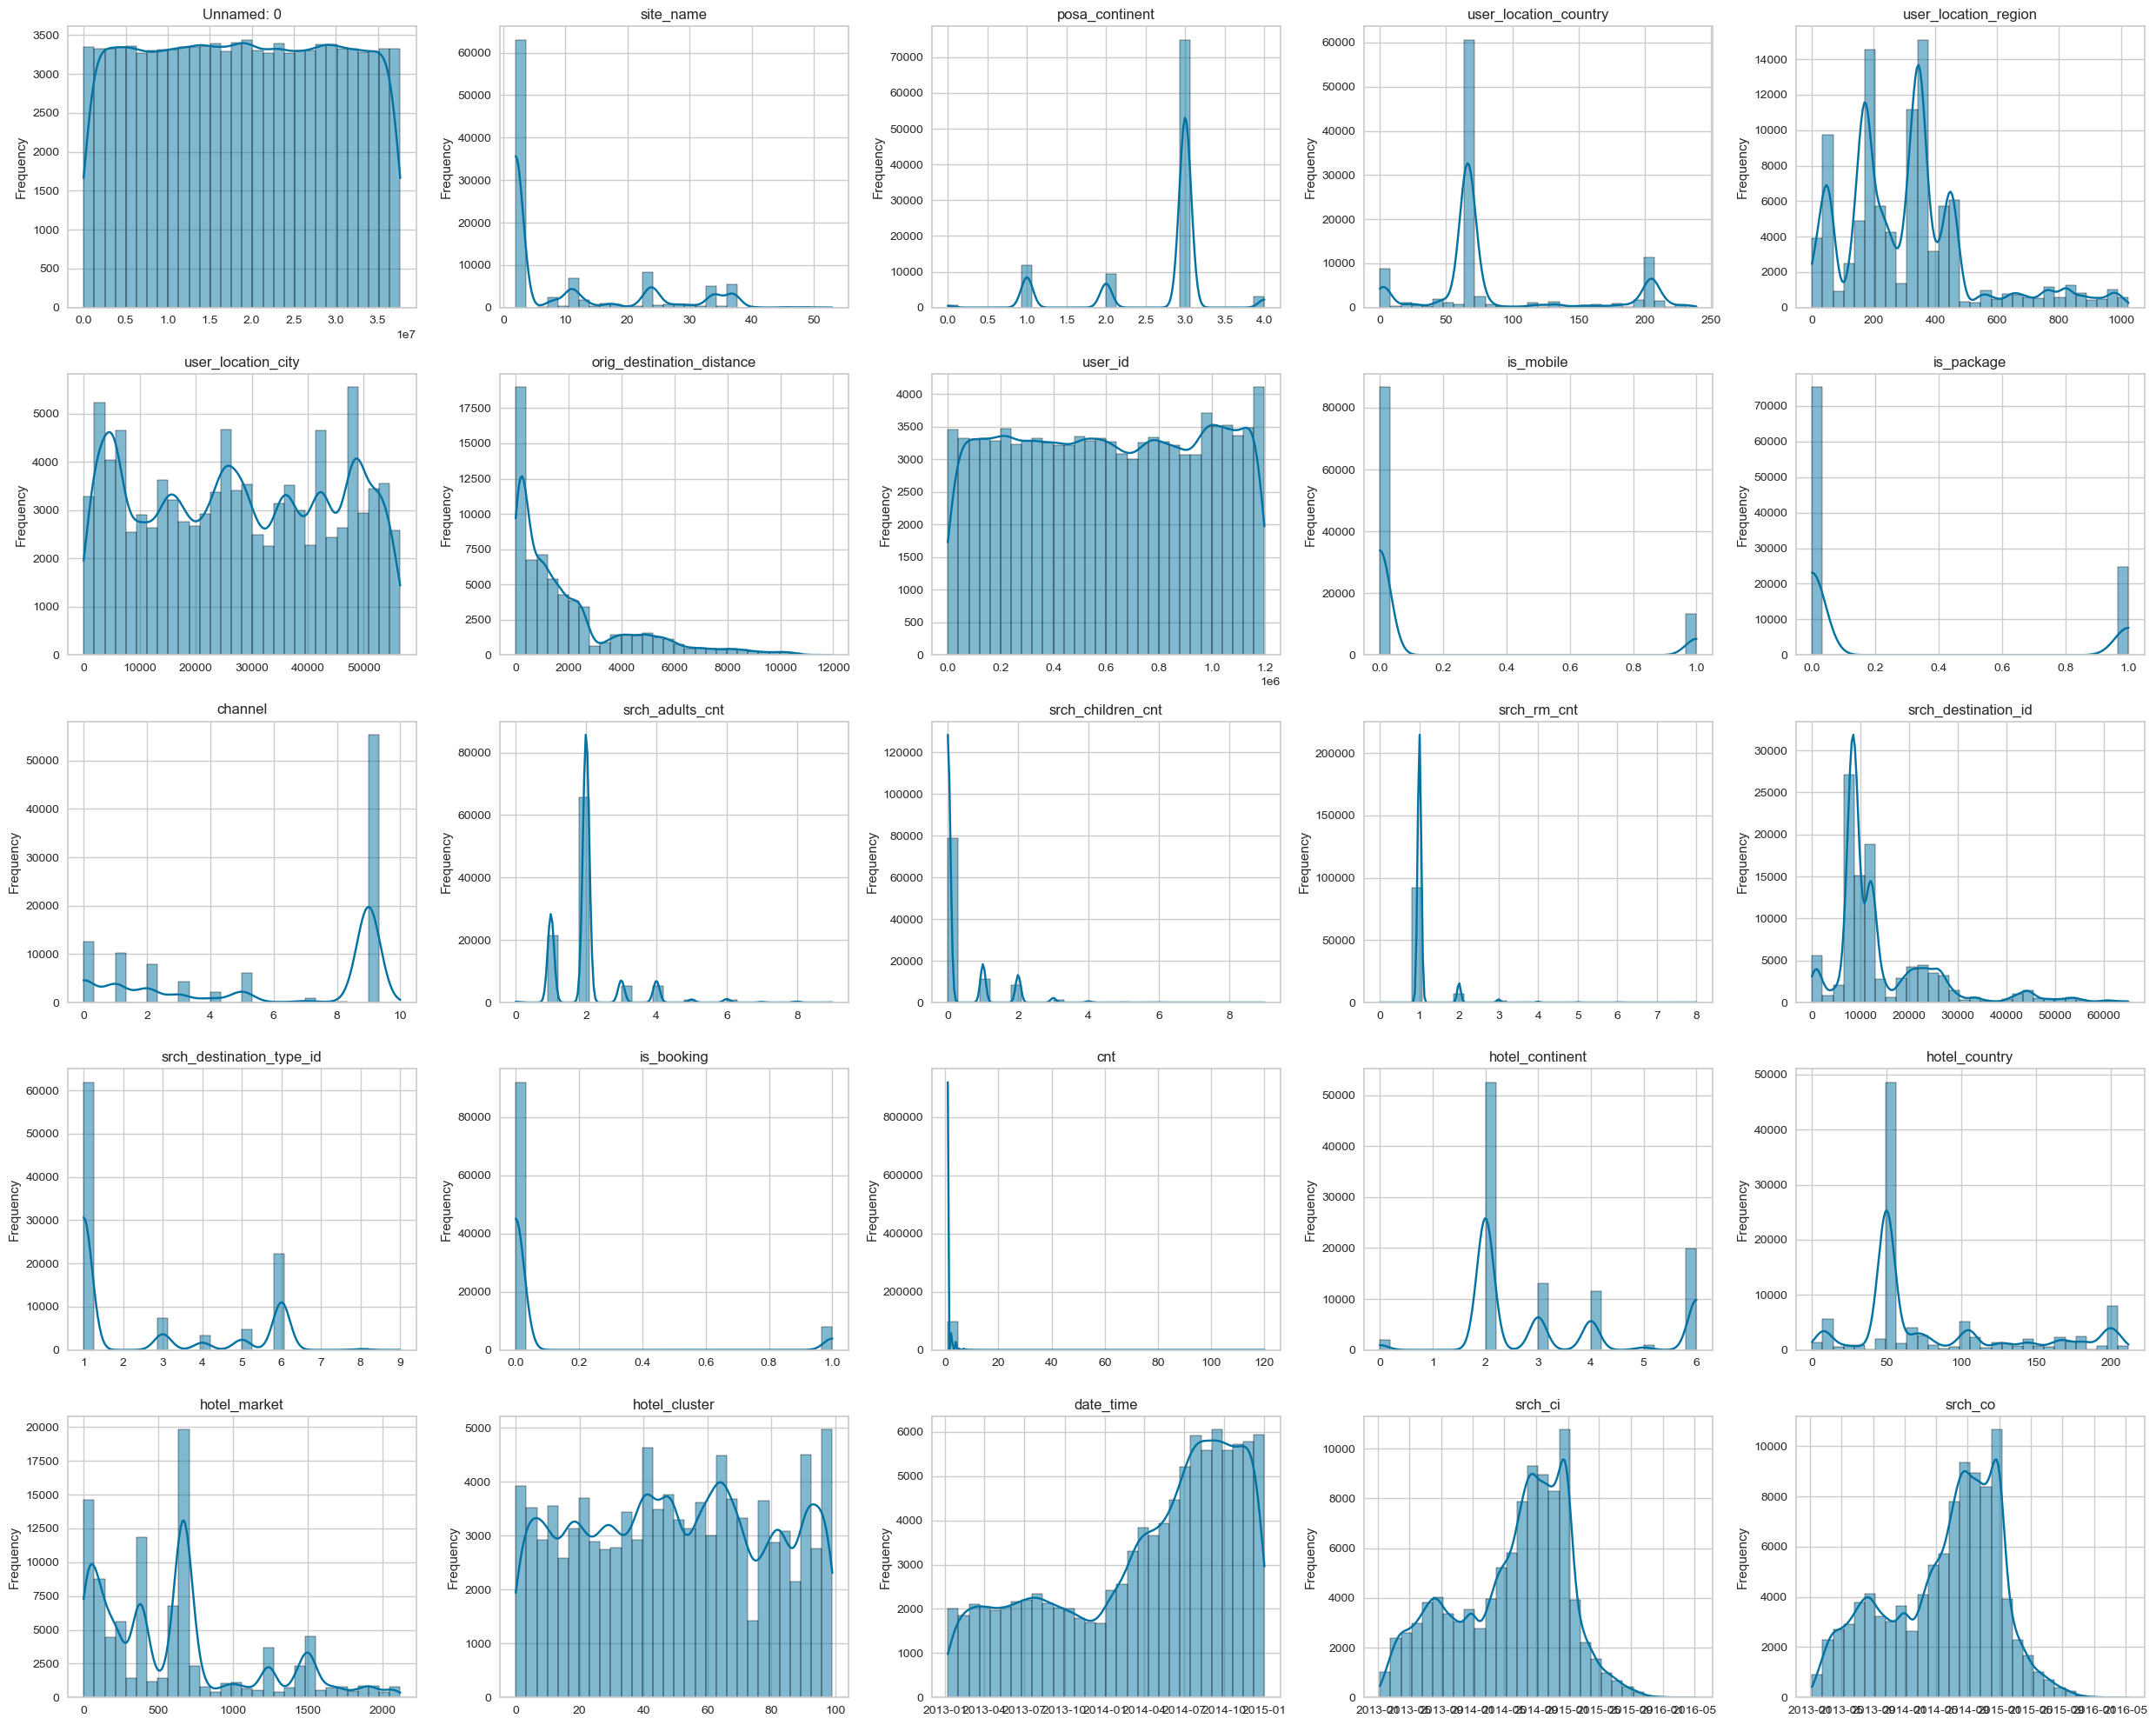

In [21]:
numeric_cols = raw.select_dtypes(include='number').columns
date_cols = raw.select_dtypes(include='datetime').columns

all_cols = list(numeric_cols) + list(date_cols)

n_cols = 5  # plots per row
n_rows = -(-len(all_cols) // n_cols)  # ceiling division

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(all_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(raw[col].dropna(), kde=True, bins=30)
    
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

count of unique values:  41


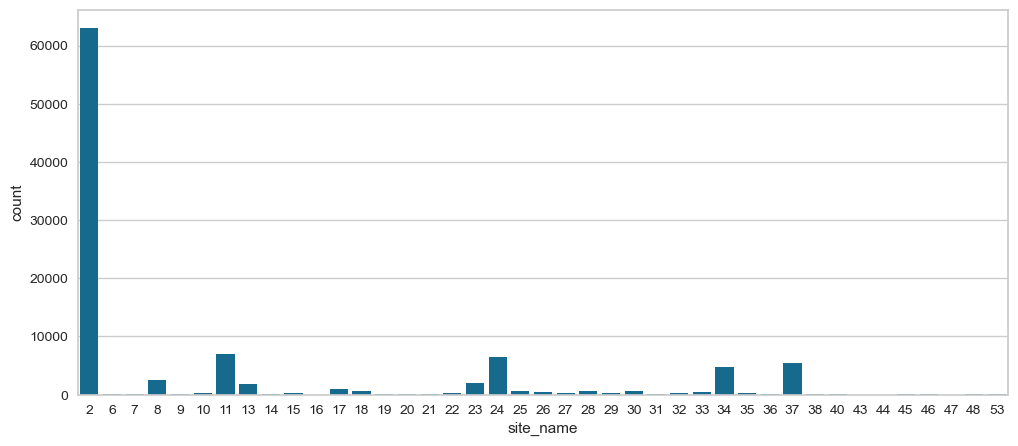

In [22]:
# site_name
plt.figure(figsize=(12, 5))
sns.countplot(data=raw, x='site_name')
print('count of unique values: ', raw['site_name'].nunique())

In [23]:
site_count = raw['site_name'].value_counts().reset_index()
site_count['cumu_count'] = site_count['count'].cumsum()
site_count['cumu_count_pct'] = (site_count['cumu_count'] / site_count['count'].sum()).round(4)
site_count.head()

,site_name,count,cumu_count,cumu_count_pct
0,2,63028,63028,0.6303
1,11,6955,69983,0.6998
2,24,6446,76429,0.7643
3,37,5426,81855,0.8186
4,34,4686,86541,0.8654


While there are 41 sites available, sites #2, 11, 24, 37, 34 are the top 5 most visited sites and comprise of 86% of the searches. Site #2 is the most visited, it alone representing over 60% of the visits.

count of unique country values:  201


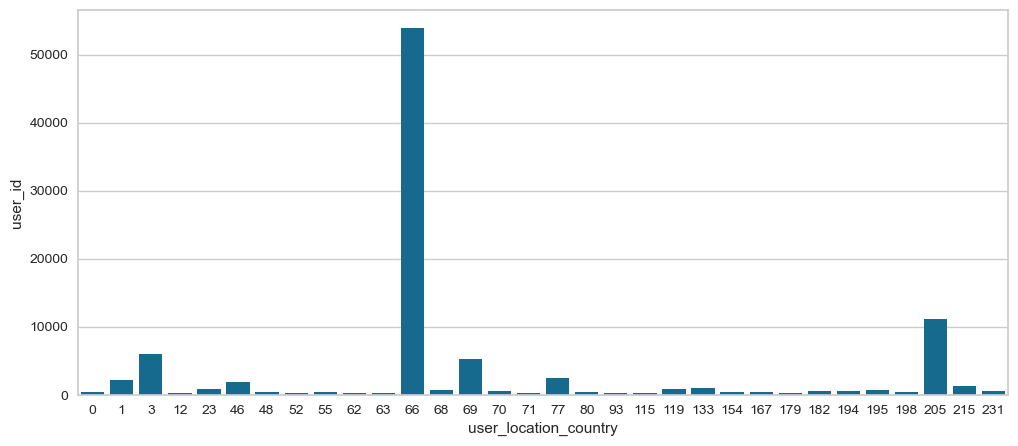

In [25]:
# user_location_country
country = raw.groupby(['user_location_country'])['user_id'].count()
pop_country = country[country >= 200].reset_index()

plt.figure(figsize=(12, 5))
sns.barplot(data=pop_country, x='user_location_country', y='user_id')
print('count of unique country values: ', country.count())

In [26]:
country_count = raw['user_location_country'].value_counts().reset_index()
country_count['cumu_count'] = country_count['count'].cumsum()
country_count['cumu_count_pct'] = (country_count['cumu_count'] / country_count['count'].sum()).round(4)
country_count.head()

,user_location_country,count,cumu_count,cumu_count_pct
0,66,53910,53910,0.5391
1,205,11112,65022,0.6502
2,3,5982,71004,0.7100
3,69,5212,76216,0.7622
4,77,2492,78708,0.7871


Similar to site_name, while there are 201 countries in this analysis, country #66 comprises 54% of the search, followed by #205 contributing to another 10% of the total search. Given booking.com is headquartered in Europe, it is likely the users are mainly NA- and Euro-based.

<Axes: xlabel='orig_destination_distance', ylabel='Count'>

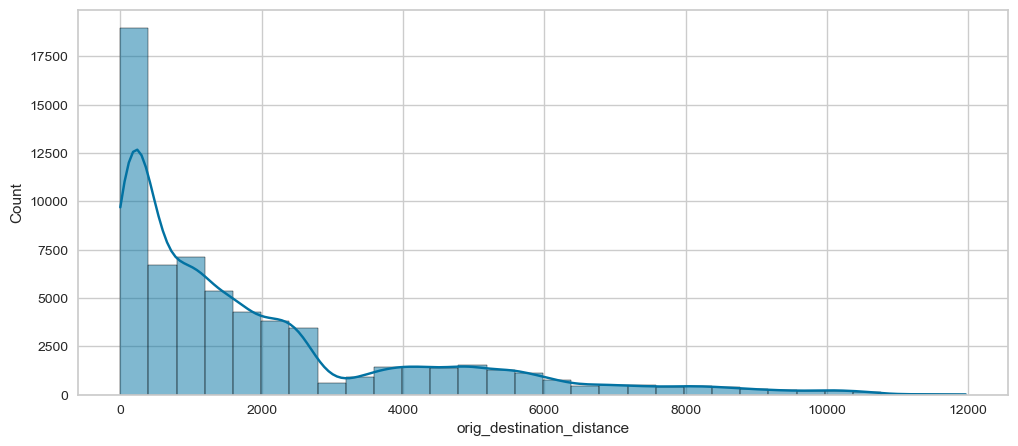

In [28]:
# orig_destination_distance
plt.figure(figsize=(12, 5))
sns.histplot(data=raw, x='orig_destination_distance', bins=30, kde=True)

From the data available on hand, the searches are clustered with short-distance trips and spreaded to long-distance trips. 

count of unique values:  11
% of Channel 9 to all:  0.55352


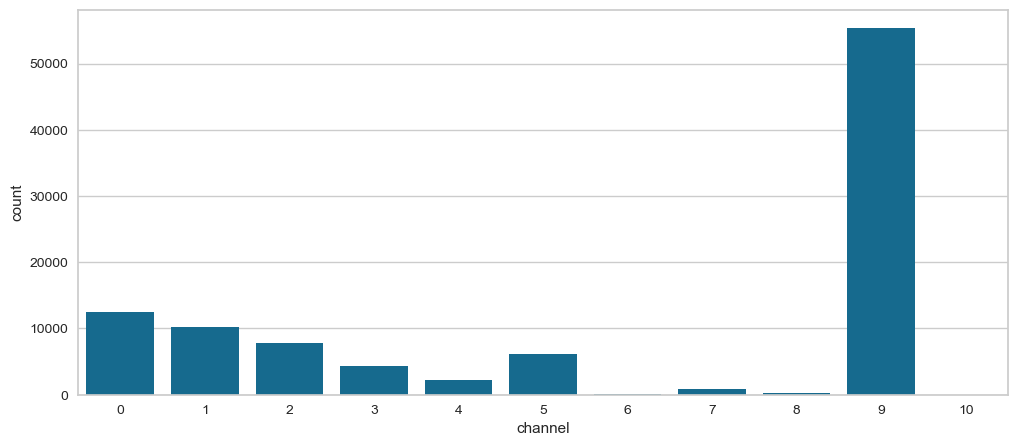

In [30]:
# channel
plt.figure(figsize=(12, 5))
sns.countplot(data=raw, x='channel')
print('count of unique values: ', raw['channel'].nunique())
print('% of Channel 9 to all: ', raw[raw['channel']==9].shape[0]/raw.shape[0])

Channel 9 has the highest visits among different channels, counting over 55% of the total searches in this analysis.

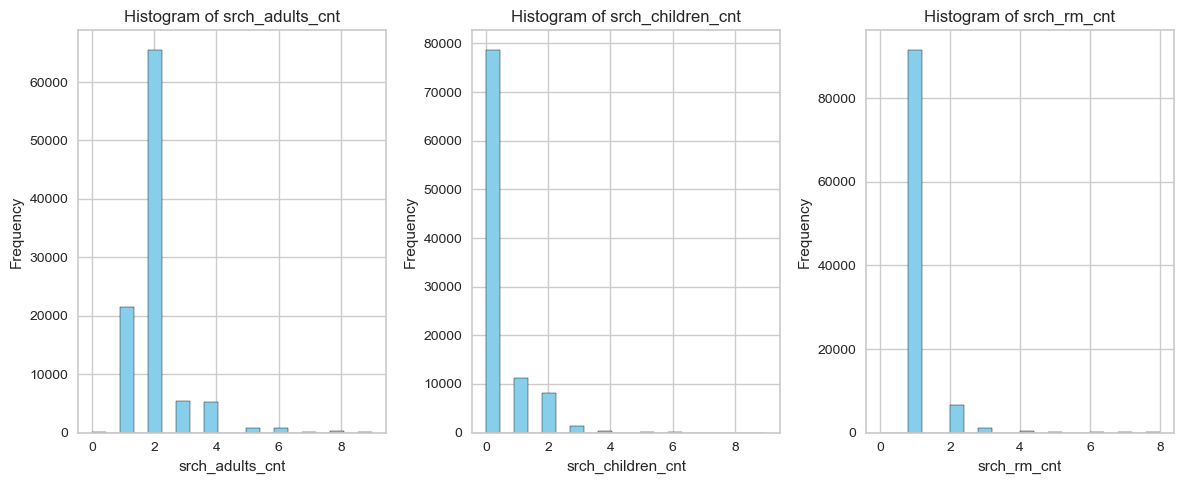

In [32]:
# Adult/children/room counts
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=False)

cols = ['srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt']

# Plot each histogram
for i, col in enumerate(cols):
    axes[i].hist(raw[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

From adult/children/room count, we noticed that the majority of the searches are for 2 adults, 0 children, and 1 room. This seems to be the default setting at most booking sites unless specified otherwise. This also implies that most of the users might be a smaller group of young adults travelling together.

count of unique values:  8


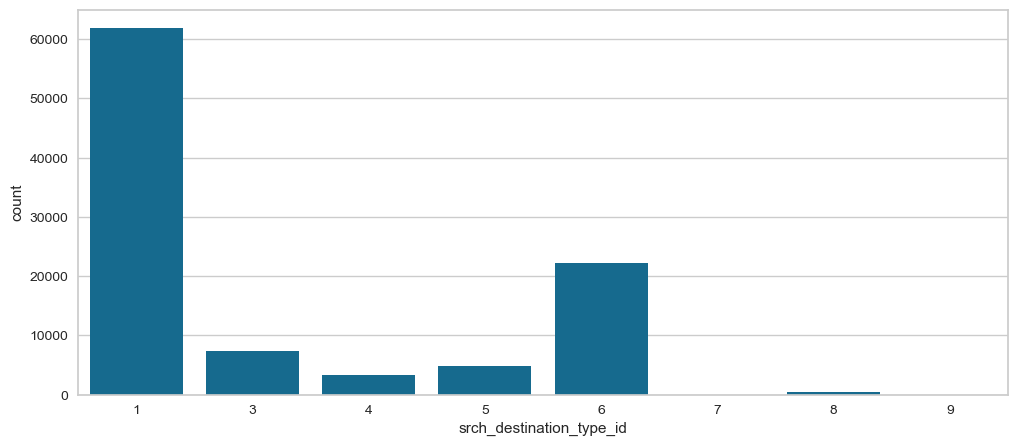

In [34]:
# srch_destination_type_id
plt.figure(figsize=(12, 5))
sns.countplot(data=raw, x='srch_destination_type_id')
print('count of unique values: ', raw['srch_destination_type_id'].nunique())

From trip destinations, type #1 and 6 are the most popular among all destinations.

In [36]:
# binary features
cols = ['is_mobile', 'is_package', 'is_booking']
res = pd.DataFrame()

for col in cols:
    res[col] = raw[col].value_counts()
res = res.T
res['rate'] = res[1]/res.sum(axis=1)
res

is_mobile,0,1,rate
is_mobile,86623,13377,0.13377
is_package,75186,24814,0.24814
is_booking,92007,7993,0.07993


We notice 13% of the searches are done on mobile, 25% are looking for a package, and the final booking rate is about 8%.

## 1.3 Multi-variable Analysis

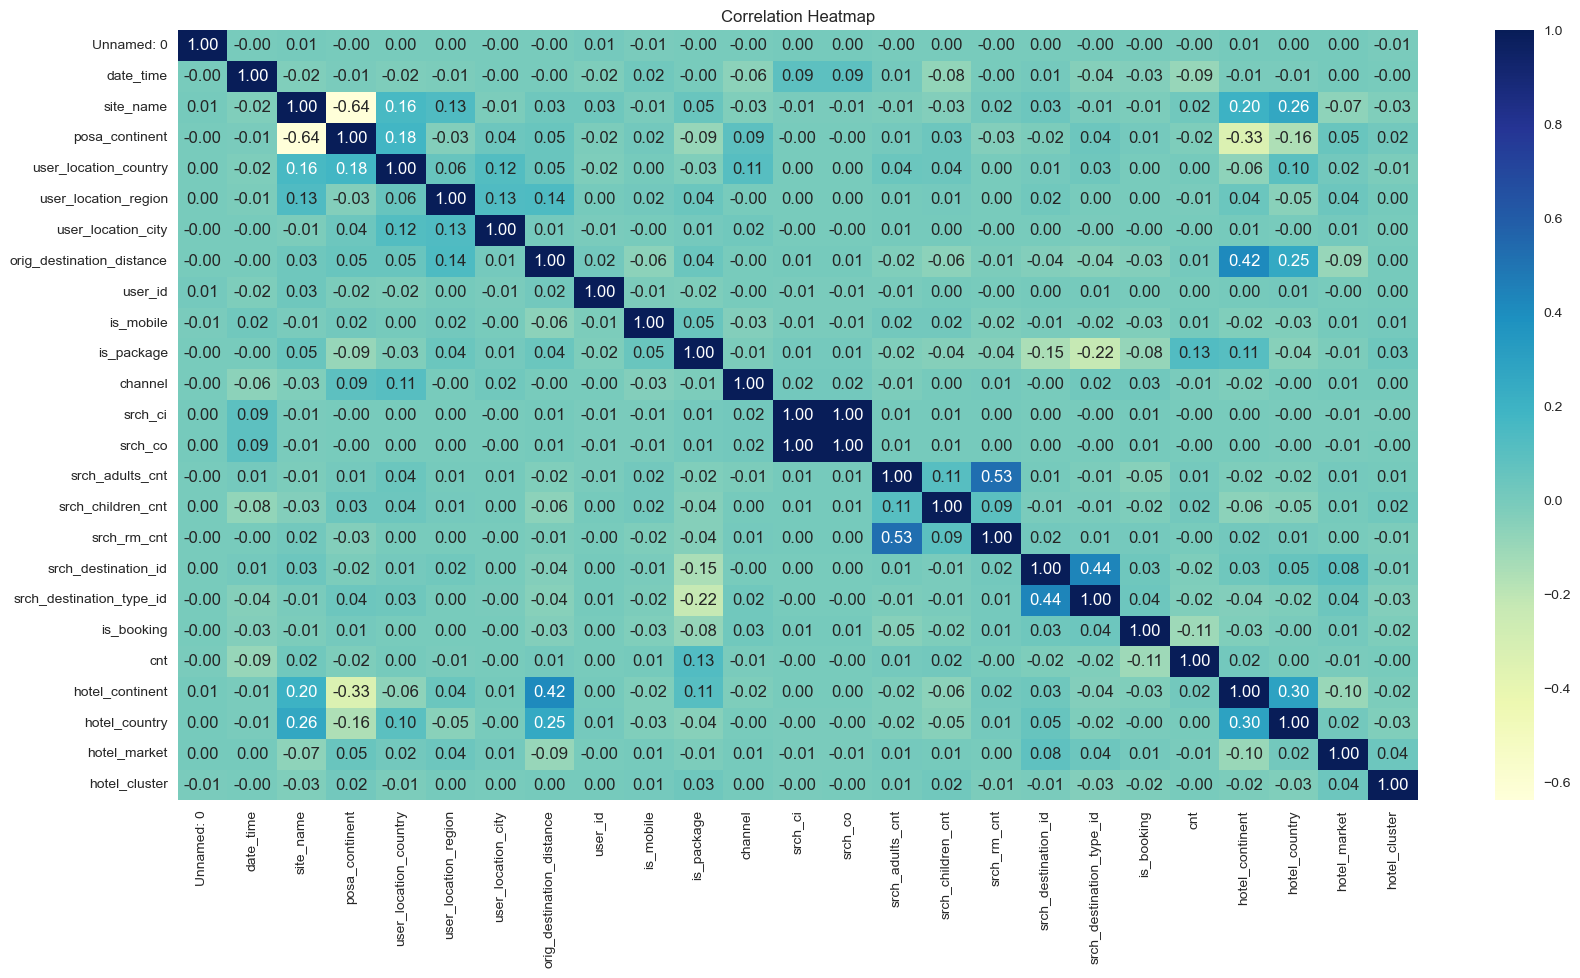

In [39]:
# correlation heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(raw.corr(method='pearson'), annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

We observe mostly 0 linear correlation among features. This is a positive sign indicating we could comfortably using almost all input features without the concern of multicollinearity. Notably, there is a positive correlation between adult count and room count. This is also intuitive, as more rooms are needed to accommodate more people.

The spearman correlation also returns a similar result.

<Axes: xlabel='is_package', ylabel='channel'>

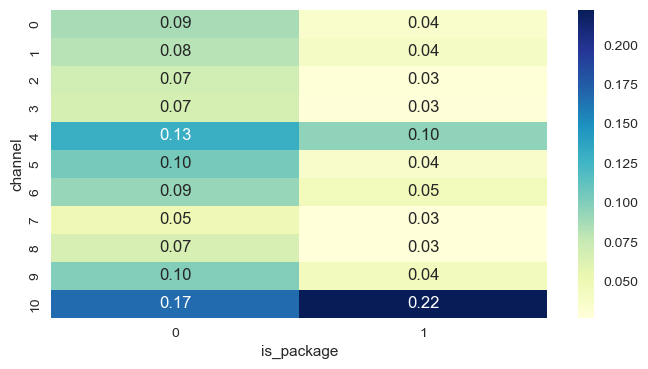

In [41]:
# channel, package, vs is_booking
pivot = raw.pivot_table(
    index='channel',
    columns='is_package',
    values='is_booking',
    aggfunc='mean'  # booking rate
)

# Plot the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(pivot.fillna(0), annot=True, cmap='YlGnBu', fmt='.2f')

In [42]:
pkg_df = raw[raw['is_package'] == 1]
no_pkg_df = raw[raw['is_package'] == 0]

pkg_booking_rate = pkg_df['is_booking'].mean()
no_pkg_booking_rate = no_pkg_df['is_booking'].mean()
pooled_rate = raw['is_booking'].mean()

z_score = (pkg_booking_rate - no_pkg_booking_rate) / np.sqrt(pooled_rate*(1-pooled_rate)*(1/pkg_df.shape[0]+1/no_pkg_df.shape[0]))
print(f"z_score: {z_score: .4f}")

p_value = np.around(stats.norm.cdf(z_score),decimals=10)
print(f"p_value: {p_value: .4f}")

z_score: -25.7116
p_value:  0.0000


As p-value < 0.05, we conclude there is a statistical significance in the non-package search having a higher booking rate compared to the package trip search. Although Channels #4 and 10 show the highest booking rate, this data might be skewed as both channels have a limited number of searches and are worth further investigation if they indeed have higher booking rate.

<Axes: xlabel='is_mobile', ylabel='posa_continent'>

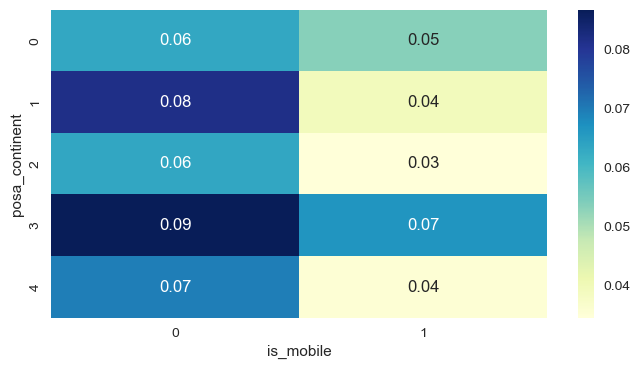

In [44]:
# user continent, mobile, vs is_booking
pivot = raw.pivot_table(
    index='posa_continent',
    columns='is_mobile',
    values='is_booking',
    aggfunc='mean'  # booking rate
)

# Plot the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(pivot.fillna(0), annot=True, cmap='YlGnBu', fmt='.2f')

Given the continent, there is also a difference in the booking rate whether the search is on mobile devices. It suggests a greater adoption of mobile visits in continents # 0 and 3. On the other hand, mobile searches lead to fewer bookings in continents# 1, 2 and 4. Thus, it is suggested to run the campaign on desktop traffic only.

In [46]:
# User funnel
user_action = raw.pivot_table(
    values='date_time',
    index = 'user_id',
    columns = 'is_booking',
    aggfunc = 'count'
).reset_index().fillna(0)

user_action['tot_action'] = user_action[0] + user_action[1]

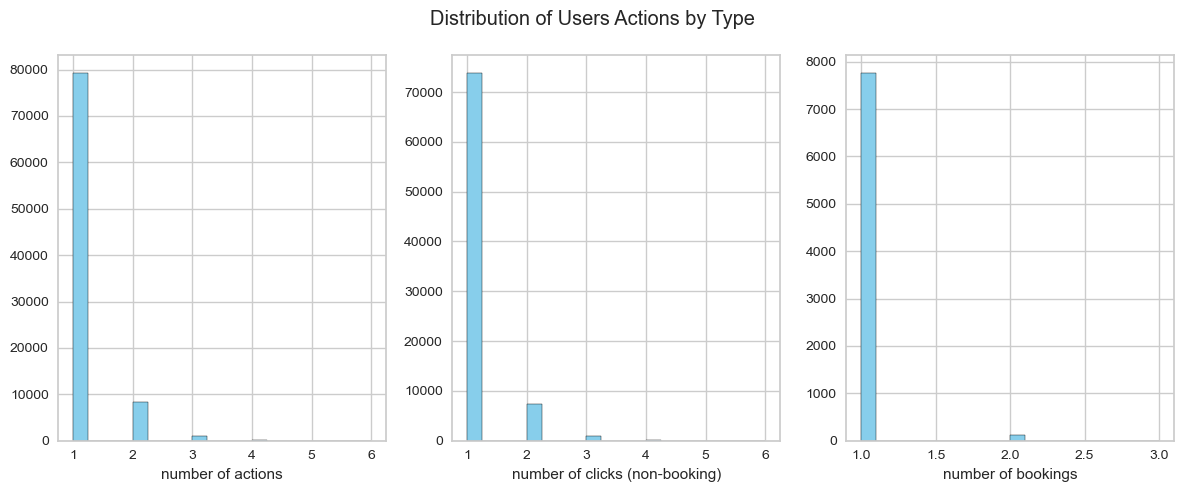

In [47]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols = 3, figsize=(12,5))
ax1.hist(user_action['tot_action'], bins=20, color='skyblue', edgecolor='black')
ax1.set_xlabel('number of actions')

user_clicks = user_action[user_action[0]>=1]
ax2.hist(user_clicks[0], bins=20, color='skyblue', edgecolor='black')
ax2.set_xlabel('number of clicks (non-booking)')

user_booking = user_action[user_action[1]>=1]
ax3.hist(user_booking[1], bins=20, color='skyblue', edgecolor='black')
ax3.set_xlabel('number of bookings')

plt.suptitle('Distribution of Users Actions by Type')
plt.tight_layout()

From the user funnel, we notice that the majority of users in this dataset made only 1 search, and most of them did not end up booking. For users who make bookings, we can tell from the dataset that users usually make bookings on their first search. Users also tend to make one-off trip rather than periodic bookings from the dataset given.

In [49]:
channel_booking = raw.pivot_table(
    values = 'is_booking',
    index = 'channel',
    aggfunc = ['mean','sum', 'count']
).reset_index()

channel_booking.columns = ['channel', 'booking_rate' ,'booking_count', 'total_searches']
channel_booking = channel_booking.sort_values(by='total_searches', ascending = False)
channel_booking

,channel,booking_rate,booking_count,total_searches
9,9,0.085381,4726,55352
0,0,0.071948,901,12523
1,1,0.069690,716,10274
2,2,0.060490,474,7836
5,5,0.094349,581,6158
3,3,0.060400,266,4404
4,4,0.120784,265,2194
7,7,0.043157,35,811
8,8,0.055351,15,271
6,6,0.067901,11,162


In [50]:
# run z_test to statistically check the booking rate between channels
total_rows = raw.shape[0]
total_booking = raw['is_booking'].sum()
pooled_booking = raw['is_booking'].mean()

channel_booking['rest_searches'] = total_rows - channel_booking['total_searches']
channel_booking['rest_bookings'] = total_booking - channel_booking['booking_count']
channel_booking['rest_booking_rate'] = channel_booking['rest_bookings'] / channel_booking['rest_searches']
channel_booking['rest_booking_rate1'] = (pooled_booking*total_booking - channel_booking['booking_count']*channel_booking['booking_rate'])/channel_booking['rest_bookings']
channel_booking['diff_rate'] = channel_booking['booking_rate'] - channel_booking['rest_booking_rate']

channel_booking['z_score'] = channel_booking['diff_rate'] / (np.sqrt(pooled_booking*(1-pooled_booking)*(1/channel_booking['total_searches']+1/channel_booking['rest_searches'])))
channel_booking['p_value'] = stats.norm.cdf(channel_booking['z_score']).round(6)
channel_booking['significant?'] = [(lambda x: 1 if x > 0.9 else -1 if x < 0.1 else 0)(i) for i in channel_booking['p_value']]
channel_booking                                                     

,channel,booking_rate,booking_count,total_searches,rest_searches,rest_bookings,rest_booking_rate,rest_booking_rate1,diff_rate,z_score,p_value,significant?
9,9,0.085381,4726,55352,44648,3267,0.073172,0.072045,0.012208,7.077231,1.000000,1
0,0,0.071948,901,12523,87477,7092,0.081073,0.080944,-0.009125,-3.521880,0.000214,-1
1,1,0.069690,716,10274,89726,7277,0.081102,0.080937,-0.011412,-4.040405,0.000027,-1
2,2,0.060490,474,7836,92164,7519,0.081583,0.081156,-0.021093,-6.609924,0.000000,-1
5,5,0.094349,581,6158,93842,7412,0.078984,0.078800,0.015365,4.307105,0.999992,1
3,3,0.060400,266,4404,95596,7727,0.080830,0.080602,-0.020430,-4.888198,0.000001,-1
4,4,0.120784,265,2194,97806,7728,0.079014,0.078529,0.041770,7.135170,1.000000,1
7,7,0.043157,35,811,99189,7958,0.080231,0.080092,-0.037074,-3.877458,0.000053,-1
8,8,0.055351,15,271,99729,7978,0.079997,0.079976,-0.024646,-1.494103,0.067574,-1
6,6,0.067901,11,162,99838,7982,0.079950,0.079947,-0.012048,-0.565022,0.286029,0


In summary, the dataset has been thoroughly examined. There are no duplicate entries, all missing values have been reviewed and appropriately handled, and no significant outliers were found that required removal.

From the univariate analysis, we observed that the majority of searches originate from site #2, country #66, and through channel#9. Users tend to prefer short-distance trips, typically with 2 adults, no children, and 1 room. Additionally, destination types #1 and #6 are among the most frequently searched. Mobile visits account for 13% of total traffic, and approximately 25% of visits involve users searching for package trips. The overall booking rate stands at 8%.

In the multivariate analysis, we found minimal multicollinearity among the features. Users are more likely to book when searching for non-package trips, and mobile usage shows varied impact on booking rates depending on the user’s continent. Funnel analysis revealed that most users search only once, with a low conversion rate to final bookings. Lastly, an examination of booking rates across channels shows that channels 9, 5, and 4 have significantly higher booking rates, whereas channel #2 has a notably lower booking rate compared to others.

# 2. Preprocess

In [55]:
raw_df = raw.copy()

raw_df['days_advance'] = (raw_df['srch_ci'] - raw_df['date_time']).apply(lambda x: x.days)
raw_df['trip_duration'] = (raw_df['srch_co'] - raw_df['srch_ci']).apply(lambda x: x.days)

raw_df = raw_df.loc[raw_df['days_advance'] >= -1] #-1 represents on the travel day so fine to leave as is
raw_df = raw_df.loc[raw_df['trip_duration'] >= 0] # removing data without business sense

raw_df['days_advance'] = raw_df['days_advance'].clip(lower=0, upper=270)
raw_df['trip_duration'] = raw_df['trip_duration'].clip(upper=90)

print(raw_df.shape)
print(raw_df.columns)

(99851, 27)
Index(['Unnamed: 0', 'date_time', 'site_name', 'posa_continent',
       'user_location_country', 'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster', 'days_advance', 'trip_duration'],
      dtype='object')


In [56]:
unique_new = raw_df[['days_advance', 'trip_duration']].nunique()
unique_new.reset_index(name='count').sort_values(by='count')

,index,count
1,trip_duration,48
0,days_advance,271


In [57]:
bins = [0, 300, 2500, raw_df['orig_destination_distance'].max()]
labels = [0,1,2]
raw_df['distance_category'] = pd.cut(raw_df['orig_destination_distance'], bins=bins, labels=labels)

bins_kid = [-0.1, 0.1, 2, raw_df['srch_children_cnt'].max()]
labels_kid = [0,1,2]
raw_df['kid_group'] = pd.cut(raw_df['srch_children_cnt'], bins=bins_kid, labels=labels_kid)


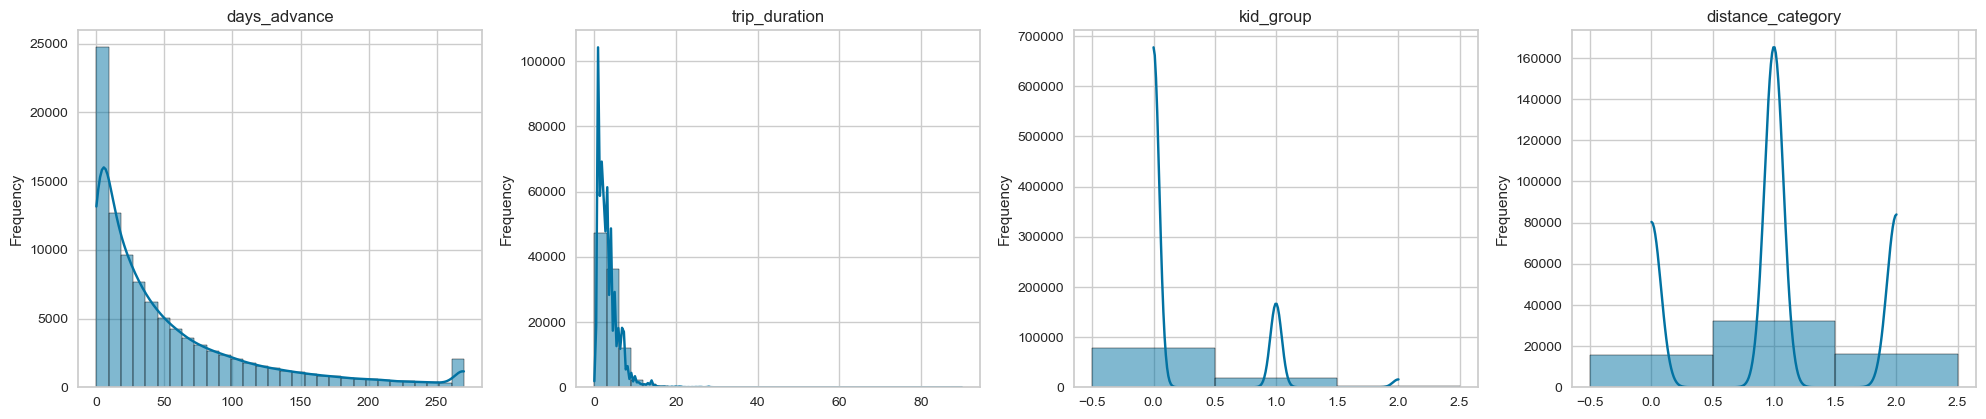

In [58]:
new_cols = ['days_advance', 'trip_duration', 'kid_group', 'distance_category']

n_cols = 5  # plots per row
n_rows = -(-len(all_cols) // n_cols)  # ceiling division

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(new_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(raw_df[col].dropna(), kde=True, bins=30)
    
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [59]:
# cluster
features = ['is_package', 'kid_group', 'distance_category', 'srch_rm_cnt', 
            'days_advance','trip_duration', 'srch_adults_cnt']

In [60]:
X = raw_df[features].dropna()
print(X.shape)
X.head()

(63830, 7)


,is_package,kid_group,distance_category,srch_rm_cnt,days_advance,trip_duration,srch_adults_cnt
0,1,0,1,1,41.0,4.0,2
1,0,0,0,1,0.0,1.0,2
2,1,0,2,1,171.0,7.0,2
3,0,0,0,1,1.0,1.0,2
5,0,0,0,1,0.0,1.0,2


In [61]:
X_cluster = X.copy()

In [62]:
scaler = StandardScaler()
X_cluster_scaled = pd.DataFrame(scaler.fit_transform(X_cluster),
                        columns=X_cluster.columns,
                        index=X_cluster.index)

print(X_cluster_scaled.shape)
X_cluster_scaled.tail()

(63830, 7)


,is_package,kid_group,distance_category,srch_rm_cnt,days_advance,trip_duration,srch_adults_cnt
99993,-0.568293,-0.506613,-0.015517,-0.242239,-0.691027,-0.800708,-1.154854
99995,-0.568293,-0.506613,-0.015517,-0.242239,0.711449,0.255726,-0.039576
99996,-0.568293,-0.506613,-0.015517,-0.242239,-0.836111,-0.800708,-1.154854
99998,1.759657,-0.506613,-1.432478,-0.242239,-0.674907,-0.448564,-0.039576
99999,-0.568293,1.624472,-0.015517,-0.242239,-0.658786,-0.096419,-0.039576


# 3. Segment Analysis

We first using the Elbow method to determine the optimal k groups, then applying k-means algorithm to assign each user the customer segmentation it belongs to.

## 3.1 Choosing k

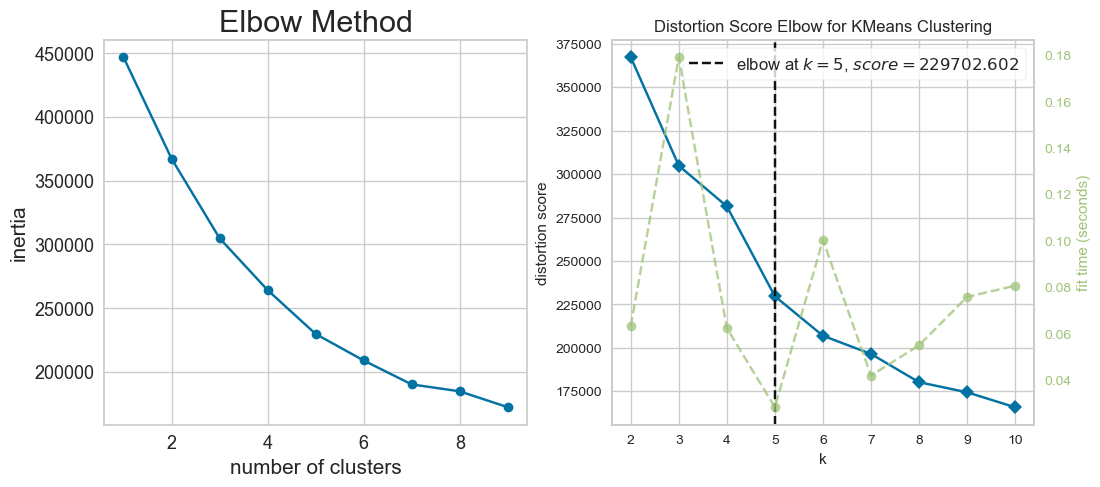

<Figure size 800x550 with 0 Axes>

In [65]:
#Elbow method
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

inertia = []

for i in range(1,10):
    kmeans = KMeans(n_clusters=i,init='k-means++',random_state=42)
    # k-means++ is an algorithm for choosing the initial values (or "seeds") for the k-means clustering algorithm.
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,5))

# First Plot
ax1.plot(range(1,10),inertia,marker='o',linestyle='-')
ax1.xaxis.set_tick_params(labelsize=13)
ax1.yaxis.set_tick_params(labelsize=13)
ax1.set_xlabel("number of clusters",fontsize=15)
ax1.set_ylabel('inertia',fontsize=15)
ax1.set_title("Elbow Method",fontsize=22)

# Second Plot
Elbow_M = KElbowVisualizer(KMeans(),k=10)
Elbow_M.fit(X_cluster_scaled)
ax2 = Elbow_M.show()

plt.tight_layout()

## 3.2 k-means

In [68]:
# Initiating KMeans. n_clusters = 4
km = KMeans(n_clusters=4, max_iter=100, random_state=42)

# Fit model and predict clusters
yhat = km.fit_predict(X_cluster_scaled)
X_cluster_scaled["clusters_2D"] = yhat

# Adding the Clusters feature to the dataframe before scaling
X_cluster["clusters_2D"] = yhat

X_cluster.head()

,is_package,kid_group,distance_category,srch_rm_cnt,days_advance,trip_duration,srch_adults_cnt,clusters_2D
0,1,0,1,1,41.0,4.0,2,0
1,0,0,0,1,0.0,1.0,2,3
2,1,0,2,1,171.0,7.0,2,0
3,0,0,0,1,1.0,1.0,2,3
5,0,0,0,1,0.0,1.0,2,3


In [69]:
# Initiating PCA to reduce dimentions to 2
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(X_cluster_scaled) 
raw_2D = pd.DataFrame(pca.transform(X_cluster_scaled),columns=(["col1", "col2"]))
raw_2D["clusters_2D"] = yhat
raw_2D.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,63830.0,-7.235669e-18,1.721055,-13.378654,-1.718105,0.615059,1.475011,2.081336
col2,63830.0,4.853464e-17,1.250083,-2.397244,-0.484999,-0.270263,0.166669,16.400845
clusters_2D,63830.0,1.811249e+00,1.298619,0.000000,0.000000,3.000000,3.000000,3.000000


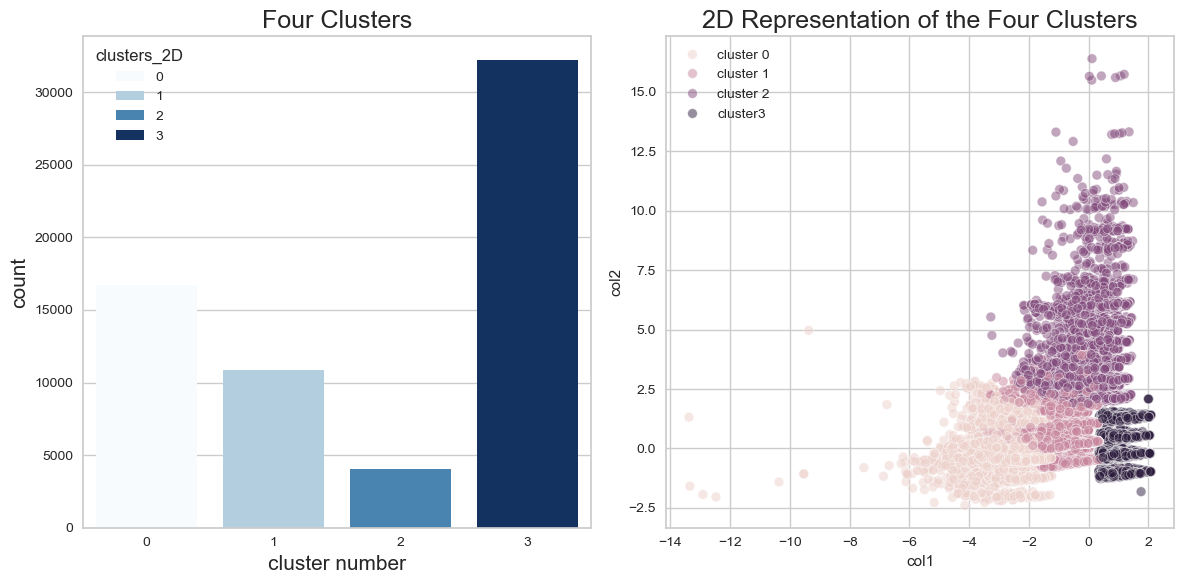

In [70]:
cluster_count = raw_2D.groupby("clusters_2D")["clusters_2D"].count().reset_index(name='count').sort_values(by='count',ascending=False)

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

# First Plot
ax1 = sns.barplot(x='clusters_2D',y='count',data=cluster_count,ax=ax1, hue='clusters_2D', palette='Blues')
ax1.set_xlabel("cluster number",fontsize=15)
ax1.set_ylabel('count',fontsize=15)
ax1.set_title("Four Clusters",fontsize=18)

ax2 = sns.scatterplot(x="col1",y="col2",data=raw_2D,hue="clusters_2D",ax=ax2,alpha=0.5)
ax2.set_title("2D Representation of the Four Clusters",fontsize=18)
legend_handles,_ = ax2.get_legend_handles_labels()
ax2.legend(legend_handles,['cluster 0','cluster 1','cluster 2','cluster3'])

plt.tight_layout()

## 3.3 Result

In [72]:
X_cluster['distance_category'] = X_cluster['distance_category'].astype('int')
X_cluster['kid_group'] = X_cluster['kid_group'].astype('int')

In [73]:
cluster_summary = X_cluster.groupby('clusters_2D').mean()
cluster_summary

,is_package,kid_group,distance_category,srch_rm_cnt,days_advance,trip_duration,srch_adults_cnt
clusters_2D,,,,,,,
0,0.829003,0.114956,1.321518,1.016046,92.005209,5.448270,1.890133
1,0.083211,1.098198,0.906399,1.038065,47.419088,2.845439,1.989334
2,0.174627,0.325871,0.980100,2.333831,57.180597,2.961443,4.334826
3,0.004002,0.000000,0.889147,1.013868,31.905436,2.330541,1.839600


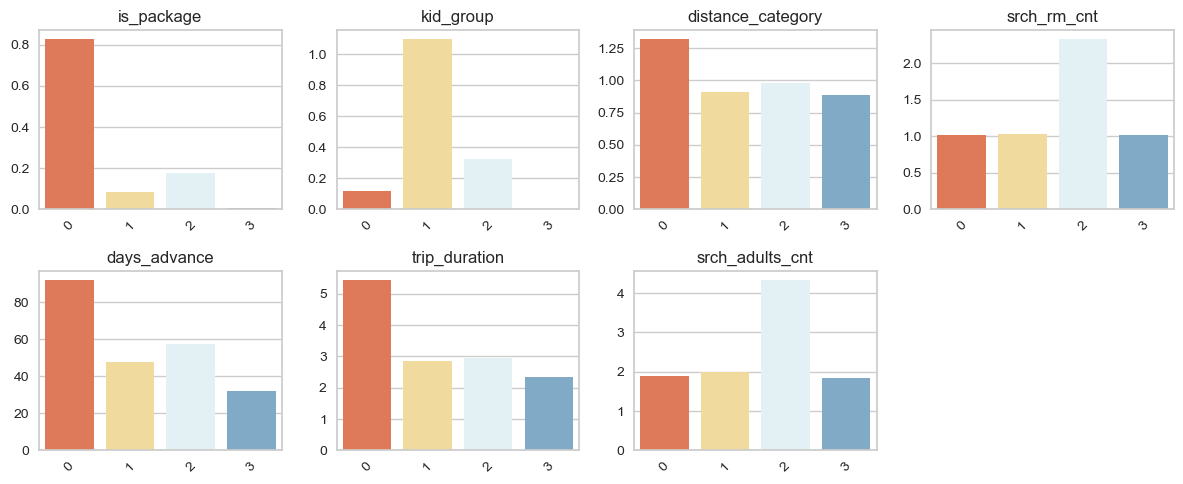

In [74]:
def plot_bar_charts_for_df(df):
    n_cols = df.shape[1]
    n_rows = (n_cols + 4 - 1) // 4  # ceiling division, 4 charts per row

    fig, axes = plt.subplots(n_rows, 4, figsize=(12, 5))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        sns.barplot(
            x=df.index.astype(str), 
            y=df[col].values, 
            ax=axes[i], 
            palette='RdYlBu'
        )
        axes[i].set_title(col)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', rotation=45)
    
    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
plot_bar_charts_for_df(cluster_summary)

Based on the analysis, the algorithm identified four distinct user clusters that exhibit the most divergent booking behaviors:

* Cluster 0: Users who tend to book long-stay package trips with approximately 3 months in advance.
* Cluster 1: Users who look for mid-distance family trips with kids.
* Cluster 2: Users opting for mid-distance and mid-duration group travel with more than 2 adults.
* Cluster 3: Users who select the default travel setting.

These clusters reflect significant variation in user travel preferences and booking patterns.

# 4. Booking Predictions

In [77]:
def evaluate_model(y_true, y_pred, y_score, model_name="Model"):
    """
    Plot ROC and Precision-Recall curves with AUC scores.

    Parameters:
    - y_true: array-like of shape (n_samples,) – Ground truth labels
    - y_score: array-like of shape (n_samples,) – Predicted probabilities for the positive class
    - model_name: str – Label for the plots (e.g., model name)
    """

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # PR
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], 'k--', label='Random')
    ax1.set_title('ROC Curve')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend()
    ax1.grid()

    # PR Curve
    ax2.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    ax2.set_title('Precision-Recall Curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend()
    ax2.grid()

    plt.suptitle(f'{model_name} Performance Curves', fontsize=14)
    plt.tight_layout()
    plt.show()

In [78]:
X_raw = X_cluster.copy()
X_raw.head()

,is_package,kid_group,distance_category,srch_rm_cnt,days_advance,trip_duration,srch_adults_cnt,clusters_2D
0,1,0,1,1,41.0,4.0,2,0
1,0,0,0,1,0.0,1.0,2,3
2,1,0,2,1,171.0,7.0,2,0
3,0,0,0,1,1.0,1.0,2,3
5,0,0,0,1,0.0,1.0,2,3


In [79]:
pop_lst = list(raw.groupby(['hotel_cluster'])['is_booking'].agg(['mean','count']).sort_values(by='mean', ascending=0).head(10).index)
pop_channel = [9, 5, 4]
print(pop_lst)

X_raw['hotel_cluster_pop'] = raw_df.loc[X_raw.index, 'hotel_cluster'].apply(lambda x: 1 if x in pop_lst else 0)
X_raw['channel_pop'] = raw_df.loc[X_raw.index, 'channel'].apply(lambda x: 1 if x in pop_channel else 0)

[42, 32, 7, 43, 13, 59, 28, 91, 95, 15]


In [80]:
add_features = ['posa_continent', 
                'is_mobile', 'srch_destination_type_id']

In [81]:
X_raw[add_features] = raw_df.loc[X_raw.index, add_features]
y = raw_df.loc[X_raw.index, 'is_booking']

In [82]:
cat_cols = ['clusters_2D', 'posa_continent', 'srch_destination_type_id']
X_ml_encoding = pd.get_dummies(X_raw, columns=cat_cols, drop_first=True)

In [83]:
X_ml_encoding

,is_package,kid_group,distance_category,srch_rm_cnt,days_advance,trip_duration,srch_adults_cnt,hotel_cluster_pop,channel_pop,is_mobile,clusters_2D_1,clusters_2D_2,clusters_2D_3,posa_continent_1,posa_continent_2,posa_continent_3,posa_continent_4,srch_destination_type_id_3,srch_destination_type_id_4,srch_destination_type_id_5,srch_destination_type_id_6,srch_destination_type_id_7,srch_destination_type_id_8
0,1,0,1,1,41.0,4.0,2,0,0,0,False,False,False,False,True,False,False,False,False,False,False,False,False
1,0,0,0,1,0.0,1.0,2,0,1,0,False,False,True,False,False,True,False,True,False,False,False,False,False
2,1,0,2,1,171.0,7.0,2,0,1,0,False,False,False,False,False,True,False,False,False,False,False,False,False
3,0,0,0,1,1.0,1.0,2,1,0,0,False,False,True,False,False,True,False,True,False,False,False,False,False
5,0,0,0,1,0.0,1.0,2,0,1,0,False,False,True,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,0,0,1,1,9.0,1.0,1,0,0,0,False,False,True,False,False,True,False,False,False,False,True,False,False
99995,0,0,1,1,96.0,4.0,2,1,0,0,False,False,True,False,False,True,False,False,False,False,True,False,False
99996,0,0,1,1,0.0,1.0,1,0,1,0,False,False,True,False,False,True,False,False,False,True,False,False,False
99998,1,0,0,1,10.0,2.0,2,0,1,0,False,False,False,False,False,True,False,False,False,False,False,False,False


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_ml_encoding, y, test_size=0.2, random_state=42, stratify=y)

In [85]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4.1 Logistic Regression

Confusion Matrix:
[[11706     0]
 [ 1060     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     11706
           1       0.00      0.00      0.00      1060

    accuracy                           0.92     12766
   macro avg       0.46      0.50      0.48     12766
weighted avg       0.84      0.92      0.88     12766



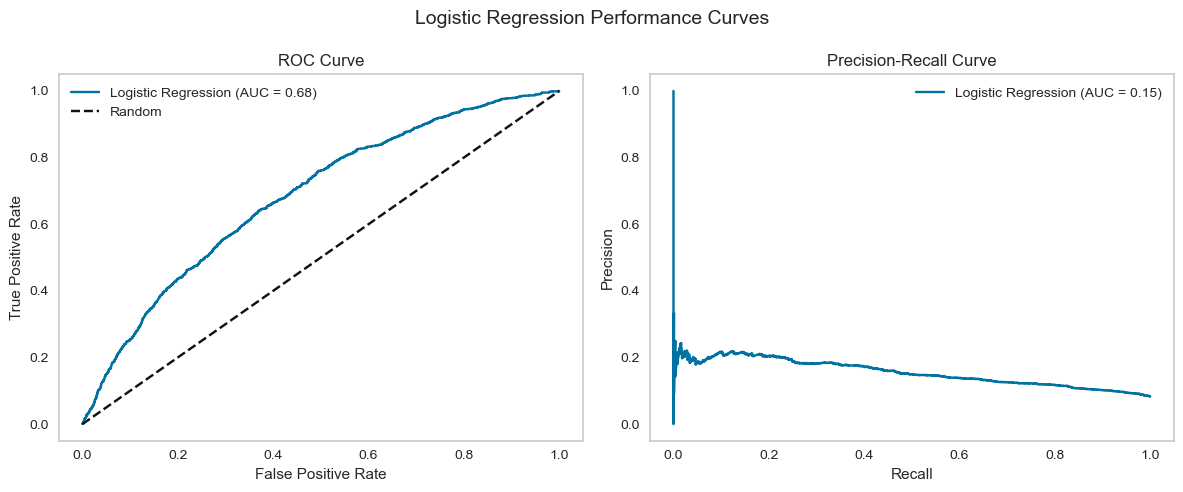

In [87]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_scores_lr = lr.predict_proba(X_test_scaled)[:, 1]

evaluate_model(y_test, y_pred_lr, y_scores_lr, model_name="Logistic Regression")

## 4.2 Random Forest

In [89]:
# 1. Define parameter grid
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# 2. Create the model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# 3. Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all CPUs
    verbose=1
)

# 4. Fit on training data
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 300]},
             scoring='f1', verbose=1)

Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
F1 Score on Test Set: 0.23005294869454082
Confusion Matrix:
[[7919 3787]
 [ 430  630]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79     11706
           1       0.14      0.59      0.23      1060

    accuracy                           0.67     12766
   macro avg       0.55      0.64      0.51     12766
weighted avg       0.88      0.67      0.74     12766



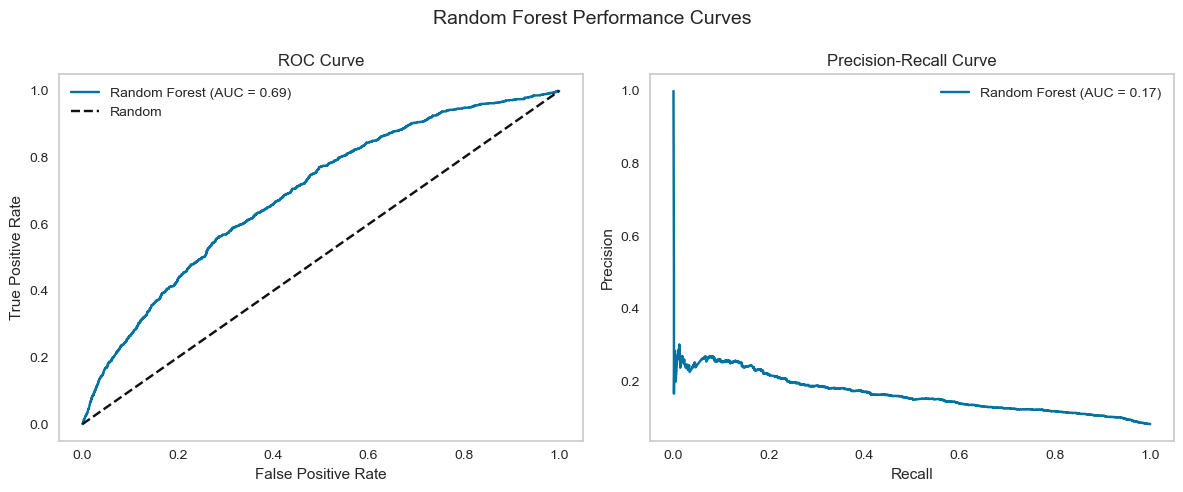

In [90]:
# 5. Evaluate on test data
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
y_scores_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

print("Best Params:", grid_search.best_params_)
print("F1 Score on Test Set:", f1_score(y_test, y_pred_rf))

evaluate_model(y_test, y_pred_rf, y_scores_rf, model_name="Random Forest")

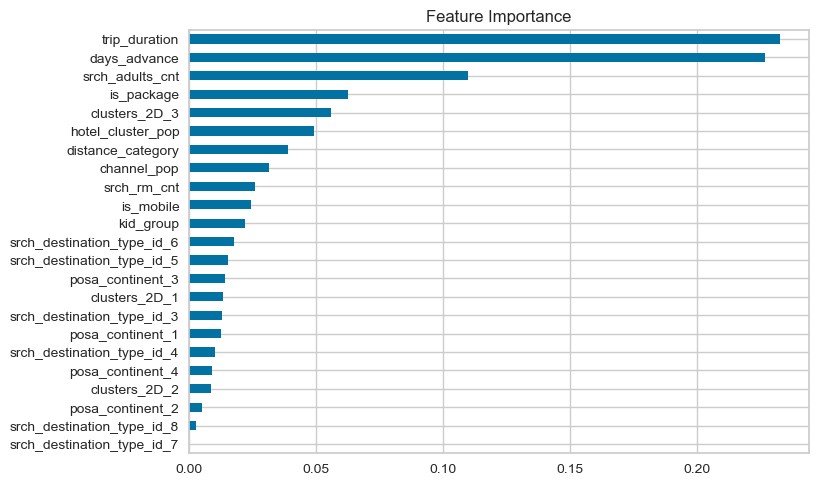

In [91]:
importances = pd.Series(best_rf.feature_importances_, index=X_ml_encoding.columns)
importances.sort_values().plot(kind='barh', title='Feature Importance')
plt.show()

## 4.3 XGBoost

In [93]:
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale,
    eval_metric='logloss',
    random_state=42
)

scorer = make_scorer(f1_score, average='binary')

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 6],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring=make_scorer(f1_score, response_method='predict', average=binary),
             verbose=1)

Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Confusion Matrix:
[[7206 4500]
 [ 349  711]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.62      0.75     11706
           1       0.14      0.67      0.23      1060

    accuracy                           0.62     12766
   macro avg       0.55      0.64      0.49     12766
weighted avg       0.89      0.62      0.70     12766



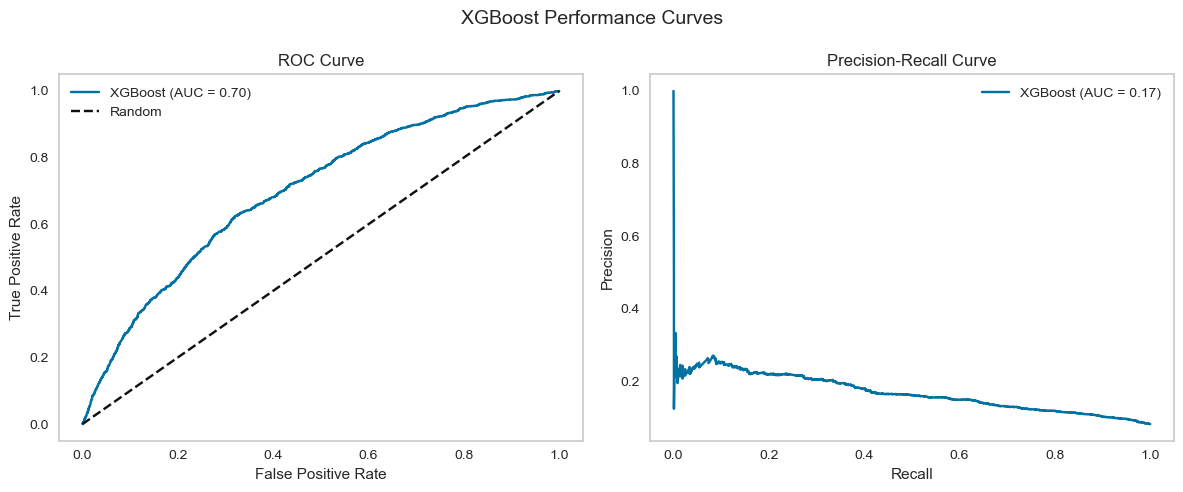

In [94]:
best_xgb = grid_search.best_estimator_

# Predict
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_score_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Best Params:", grid_search.best_params_)

evaluate_model(y_test, y_pred_xgb, y_score_xgb, model_name="XGBoost")

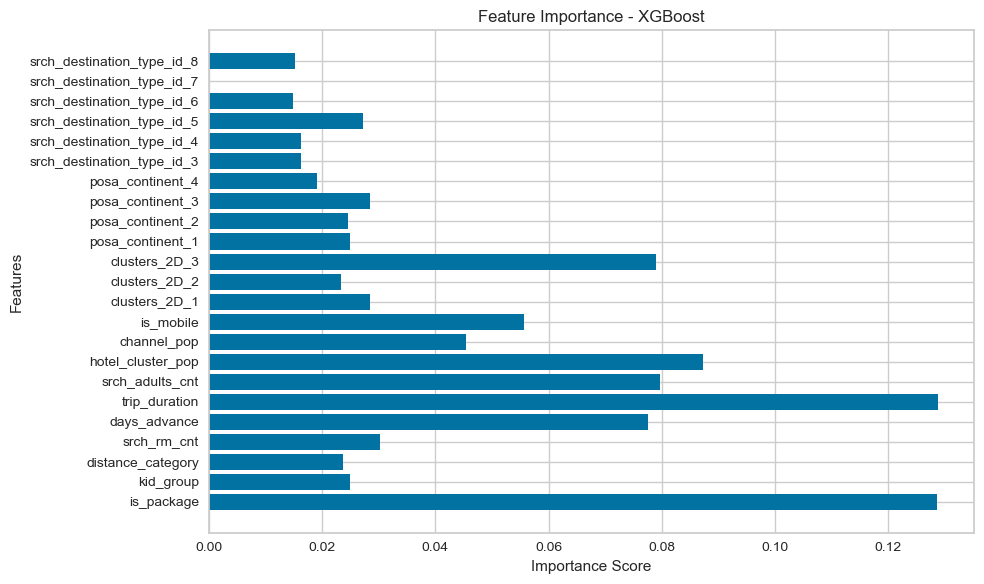

In [95]:
importances = best_xgb.feature_importances_
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"f{i}" for i in range(len(importances))]

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

## 4.4 Ensemble of the three

Confusion Matrix:
[[11201   505]
 [  908   152]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     11706
           1       0.23      0.14      0.18      1060

    accuracy                           0.89     12766
   macro avg       0.58      0.55      0.56     12766
weighted avg       0.87      0.89      0.88     12766



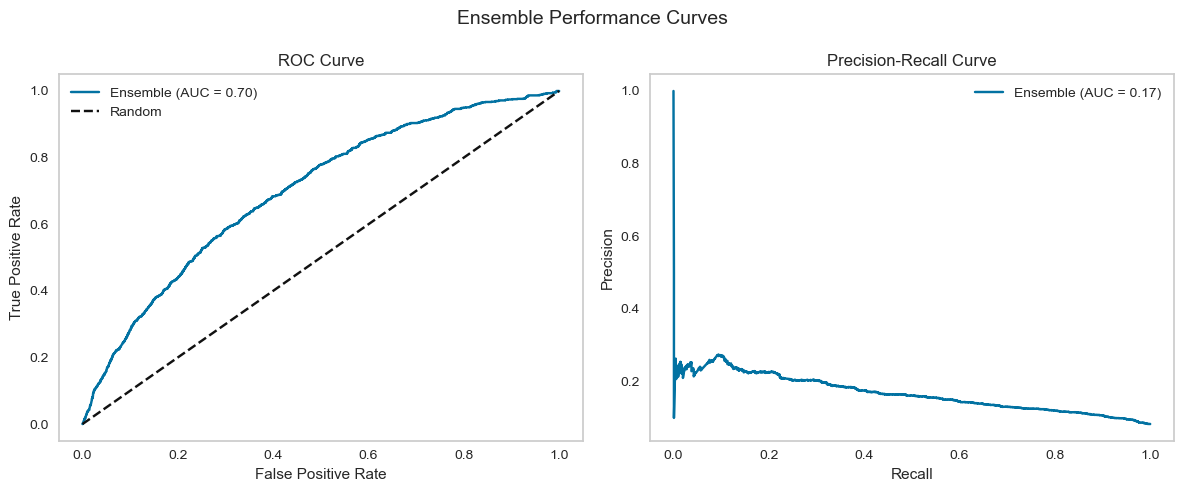

In [170]:
ensemble = VotingClassifier(estimators=[
    ('lr', lr),
    ('rf', best_rf),
    ('xgb', best_xgb)
    
], voting='soft')  # 'soft' averages predicted probabilities

# Fit ensemble
ensemble.fit(X_train_scaled, y_train)

# Evaluate
y_pred_en = ensemble.predict(X_test_scaled)
y_score_en = ensemble.predict_proba(X_test_scaled)[:, 1]

evaluate_model(y_test, y_pred_en, y_score_en, model_name="Ensemble")

This analysis applied logistic regression, random forest, XGBoost, and an ensemble model to predict user bookings based on available features. Logistic regression consistently predicted no bookings, indicating strong underfitting. In contrast, both random forest and XGBoost demonstrated improved performance, each achieving an F1-score of approximately 0.23. A precision-recall AUC (PRAUC) of 0.17 suggests the model performs about twice as well as random guessing, though there remains considerable opportunity for improvement. Incorporating additional user-specific features—such as behavioral or browsing data—could enhance model accuracy.

Feature importance analysis from the tree-based models highlighted trip duration, package type, and customer cluster as the most influential variables. Trip duration likely reflects user intent, with longer trips suggesting more serious travel planning. Package type may capture pricing sensitivity or bundling preferences, while customer cluster—derived through segmentation—likely represents demographic or behavioral distinctions. These insights not only support model interpretability but also provide actionable guidance for marketing and product strategies.

Based on overall performance, the XGBoost model is recommended for deployment.